In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import load_data as ld
from tensorflow import keras
from sklearn.utils import shuffle
from tensorflow.keras import datasets, layers, models

print(tf.__version__)

2.6.0


In [2]:
sst_train, ssh_train, nino34_train = ld.load_train("../data/train_data", op_len=17, with_obs=False)
obs_sst_train, obs_ssh_train, obs_nino34_train = ld.load_var("../data/train_data/obs", op_len=17)

ACCESS-CM2 data_shape: (1978, 24, 72) (1978, 24, 72) (1978,)
CanESM2 data_shape: (1870, 24, 72) (1870, 24, 72) (1870,)
CCSM4 data_shape: (1870, 24, 72) (1870, 24, 72) (1870,)
CESM1-CAM5 data_shape: (1870, 24, 72) (1870, 24, 72) (1870,)
CESM2 data_shape: (1978, 24, 72) (1978, 24, 72) (1978,)
CMCC-CESM data_shape: (1870, 24, 72) (1870, 24, 72) (1870,)
CMCC-CM data_shape: (1870, 24, 72) (1870, 24, 72) (1870,)
CMCC-CMS data_shape: (1870, 24, 72) (1870, 24, 72) (1870,)
CNRM-CM5 data_shape: (1870, 24, 72) (1870, 24, 72) (1870,)
CNRM-CM6-1 data_shape: (1978, 24, 72) (1978, 24, 72) (1978,)
CSIRO-Mk3-6-0 data_shape: (1870, 24, 72) (1870, 24, 72) (1870,)
FGOALS-f3-L data_shape: (1978, 24, 72) (1978, 24, 72) (1978,)
FGOALS-g3 data_shape: (1978, 24, 72) (1978, 24, 72) (1978,)
FIO-ESM data_shape: (1870, 24, 72) (1870, 24, 72) (1870,)
GFDL-CM4 data_shape: (1978, 24, 72) (1978, 24, 72) (1978,)
GFDL-ESM4 data_shape: (1978, 24, 72) (1978, 24, 72) (1978,)
MIROC5 data_shape: (1954, 24, 72) (1954, 24, 72)

In [3]:
sst_var, ssh_var, nino34_var = ld.load_var("../data/var_data", op_len=17)

var_data data_shape: (479, 24, 72) (479, 24, 72) (479,)


In [4]:
# 标准化
sst_std = sst_train.std()
ssh_std = ssh_train.std()
nino34_std = nino34_train.std()
print(sst_std, ssh_std, nino34_std)
sst_train, ssh_train, nino34_train = sst_train / sst_std, ssh_train / ssh_std, nino34_train / nino34_std
obs_sst_train, obs_ssh_train, obs_nino34_train = obs_sst_train / sst_std, obs_ssh_train / ssh_std, obs_nino34_train / nino34_std
sst_var, ssh_var, nino34_var = sst_var / sst_std, ssh_var / ssh_std, nino34_var / nino34_std

0.46396616 0.03325358 1.0005693


In [5]:
ip_var = np.concatenate([sst_var, ssh_var], axis=3)
ip_train = np.concatenate([sst_train, ssh_train], axis=3)
obs_ip_train = np.concatenate([obs_sst_train, obs_ssh_train], axis=3)
ip_train.shape, ip_var.shape , obs_sst_train.shape

((41670, 24, 72, 6), (460, 24, 72, 6), (1288, 24, 72, 3))

In [6]:
True in np.isnan(ip_train)

False

In [7]:
nino34_train.shape

(41670, 17)

In [8]:
# shuffle
ip_train, nino34_train = shuffle(ip_train, nino34_train)
obs_sst_train , obs_nino34_train = shuffle(obs_sst_train , obs_nino34_train)

In [9]:
model = models.Sequential(name="ENSO")
model.add(layers.Conv2D(50, (4, 8), activation="tanh", padding="same", input_shape=ip_train.shape[1:]))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(50, (4, 8), activation="tanh", padding="same"))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(50, (4, 8), activation="tanh", padding="same"))
model.add(layers.Flatten())
model.add(layers.Dense(50, activation="tanh"))
model.add(layers.Dense(17))
model.summary()

Model: "ENSO"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 72, 50)        9650      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 36, 50)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 36, 50)        80050     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 18, 50)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 18, 50)         80050     
_________________________________________________________________
flatten (Flatten)            (None, 5400)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                270050 

In [10]:
# Pre-train with Model Data
model.compile(optimizer=keras.optimizers.SGD(), loss="mse")
hist = model.fit(ip_train, nino34_train, validation_data=(ip_var, nino34_var), epochs=20, batch_size=400)
model.save("../data/model/exp1_pretrain")

Epoch 1/20
105/105 [==============================] - 15s 87ms/step - loss: 0.6688 - val_loss: 0.4782
Epoch 2/20
105/105 [==============================] - 8s 81ms/step - loss: 0.5165 - val_loss: 0.4470
Epoch 3/20
105/105 [==============================] - 9s 81ms/step - loss: 0.4830 - val_loss: 0.4154
Epoch 4/20
105/105 [==============================] - 9s 82ms/step - loss: 0.4654 - val_loss: 0.4268
Epoch 5/20
105/105 [==============================] - 9s 82ms/step - loss: 0.4521 - val_loss: 0.4121
Epoch 6/20
105/105 [==============================] - 9s 81ms/step - loss: 0.4416 - val_loss: 0.4273
Epoch 7/20
105/105 [==============================] - 9s 84ms/step - loss: 0.4321 - val_loss: 0.3867
Epoch 8/20
105/105 [==============================] - 8s 81ms/step - loss: 0.4237 - val_loss: 0.3947
Epoch 9/20
105/105 [==============================] - 9s 81ms/step - loss: 0.4157 - val_loss: 0.4311
Epoch 10/20
105/105 [==============================] - 9s 83ms/step - loss: 0.4084 - val_l

In [11]:
# after training
model1 = keras.models.load_model("../data/model/exp1_pretrain")
model1.compile(optimizer=keras.optimizers.SGD(learning_rate=0.0001), loss="mse")
hist1 = model1.fit(obs_ip_train, obs_nino34_train, validation_data=(ip_var, nino34_var), epochs=5, batch_size=500)
model.save("../data/model/exp1_aftertrain")

Epoch 1/5
3/3 [==============================] - 4s 962ms/step - loss: 0.7359 - val_loss: 0.4003
Epoch 2/5
3/3 [==============================] - 0s 122ms/step - loss: 0.7301 - val_loss: 0.3993
Epoch 3/5
3/3 [==============================] - 0s 128ms/step - loss: 0.7246 - val_loss: 0.3986
Epoch 4/5
3/3 [==============================] - 0s 122ms/step - loss: 0.7192 - val_loss: 0.3980
Epoch 5/5
3/3 [==============================] - 0s 119ms/step - loss: 0.7141 - val_loss: 0.3977
INFO:tensorflow:Assets written to: ../data/model/exp1_aftertrain\assets


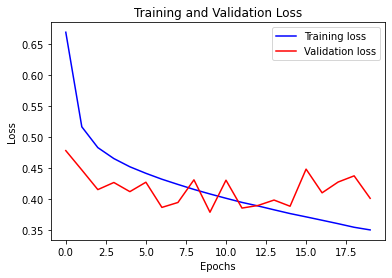

In [12]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    # plt.savefig('../pic/train_prog.png', dpi=300)
    plt.show()


visualize_loss(hist, "Training and Validation Loss")

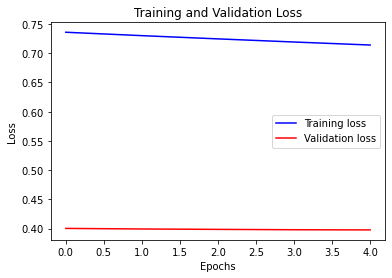

In [13]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    # plt.savefig('../pic/train_prog.png', dpi=300)
    plt.show()


visualize_loss(hist1, "Training and Validation Loss")

In [14]:
pre_nino = model.predict(ip_var)
pre_nino.shape, nino34_var.shape

((460, 17), (460, 17))

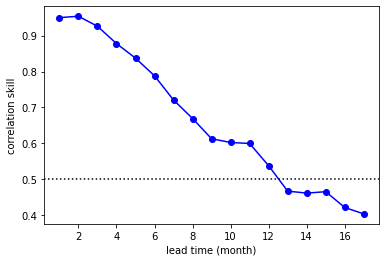

In [18]:
import scipy.stats as sts

corr_ls = []
for i in range(17):
    corr, _ = sts.pearsonr(pre_nino[:,i], nino34_var[:,i])
# corr
    corr_ls.append(corr)
plt.plot(np.arange(1, 18), corr_ls, "o-", color="blue")
plt.xlabel("lead time (month)")
plt.ylabel("correlation skill")
plt.axhline(0.5, color="k", linestyle=":")
plt.savefig("../pic/corr_skill.png")